# Ford GoBike System Data Exploration
## by Luca(MingCong) Zhou

## Preliminary Wrangling

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

In [467]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from geopy.distance import distance
from IPython.display import Image

%matplotlib inline
%config Completer.use_jedi = False

In [401]:
import sys
!{sys.executable} -m pip install numpy

In [372]:
# Since GitHub does not allow for large file, I decided loading the data from an url
file_url = "https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv"
res = requests.get(file_url)

In [373]:
# load the bytes data into pandas dataframe if status code is 200
if res.status_code != requests.codes.ok:
    print("Download Failed!")

s = str(res.content, 'utf-8')
data = StringIO(s)
df = pd.read_csv(data)

In [374]:
# high-level overview of data shape and composition
df.sample()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
55102,368,2019-02-21 11:04:14.2940,2019-02-21 11:10:23.2070,252.0,Channing Way at Shattuck Ave,37.865847,-122.267443,240.0,Haste St at Telegraph Ave,37.866043,-122.258804,5639,Subscriber,1997.0,Male,Yes


In [375]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(183412, 16)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object
duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                    

### Issues

#### Issue 1 Missing Values

1. 197 values are missing for features: start_station_id, start_station_name.
2. 8265 values are missing for features: member_birth_year and member_gender.

#### Solve Issue 1

In [376]:
# drop the rows with null values
df.dropna(inplace=True)

#### Issue 2 Misused Data Types

1. start_time, and end_time columns are in string format.
2. start_station_id, and member_birth_year columns are in float format.

#### Solve Issue 2

In [377]:
# convert the 'start_time' and 'end_time' columns to datetime format
df['start_time']= pd.to_datetime(df['start_time'])
df['end_time']= pd.to_datetime(df['end_time'])

# convert the 'start_station_id' and 'member_birth_year columns to int format
df['start_station_id'] = df['start_station_id'].astype('int')
df['member_birth_year'] = df['member_birth_year'].astype('int')

#### Inspect the cleaned dataframe

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_id         174952 non-null  int64         
 4   start_station_name       174952 non-null  object        
 5   start_station_latitude   174952 non-null  float64       
 6   start_station_longitude  174952 non-null  float64       
 7   end_station_id           174952 non-null  float64       
 8   end_station_name         174952 non-null  object        
 9   end_station_latitude     174952 non-null  float64       
 10  end_station_longitude    174952 non-null  float64       
 11  bike_id                  174952 non-null  int64         
 12  user_type       

### What is the structure of your dataset?

There are 183412 rides in the dataset with 16 features (``duration_sec``, ``start_time``, ``end_time``, ``start_station_id``, ``start_station_name``, ``start_station_latitude``, ``start_station_longitude``, ``end_station_id``, ``end_station_name``, ``end_station_latitude``, ``end_station_longitude``, ``bike_id``, ``user_type``, ``member_birth_year``, ``member_gender``, and ``bike_share_for_all_trip``). 

Most variables are numeric in nature, but the variables ``start_station_name``, ``end_station_name``, ``user_type``, ``member_gender`` and ``bike_share_for_all_trip`` are nominal factor variables.

### What is/are the main feature(s) of interest in your dataset?

I am most interested in figuring out what factors can increase the usage of our shared bicycle.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that the amount of bike usage depends on the following factors:

1. the time of the day, and the day of the week.
2. the location of the bike station.
3. the gender of the user.

## Univariate Exploration

Our goal is to figure out what factors can increase our bike usage. I will start by looking at the distance people traveled when they are using our bicycles.

### How far do people usually bike when they are using our shared bicycles?

To get the distance of rides, we need to know the starting and ending locations. The features ``start_station_latitude``, ``start_station_longitude``, ``end_station_latitude``, and ``end_station_longitude`` are provided in the datasets. These features are two GPS coordinates:

```text
                                        |
                                        |   (x1,y1)
                                        |
                                        |
                                        |                        (x2, y2)
                                --------|-----------------------------------------
                                        |
```

Remember, from high school, to find the distance between two coordinates, we can use [Euclid's theorem](https://en.wikipedia.org/wiki/Euclid's_theorem). Nevertheless, since Earth is a sphere, we can not merely apply the theorem here. However, Python has made everything so easy for us. We will use the [geopy](https://github.com/geopy/geopy) library to solve the problem.


In [379]:
# use geopy to measure distances, store it as a new feature
# for your reference: https://geopy.readthedocs.io/en/stable/#module-geopy.distance
def getDistance(startCoord, endCoord):
    """
    This function will return the distance (in km) between two coordinates.

    :param[float tuple] startCoord the starting coordinate
    :param[float tuple] endCoord the ending coordinate
    :return float, the distance between two coordinates
    """
    return distance(startCoord, endCoord).km

In [380]:
distances = list()

# calculate distance for all rows
for ride in df.itertuples():
    startCoord = (ride.start_station_latitude, ride.start_station_longitude)
    endCoord = (ride.end_station_latitude, ride.end_station_longitude)
    distances.append(getDistance(startCoord, endCoord))

df['distance'] = distances

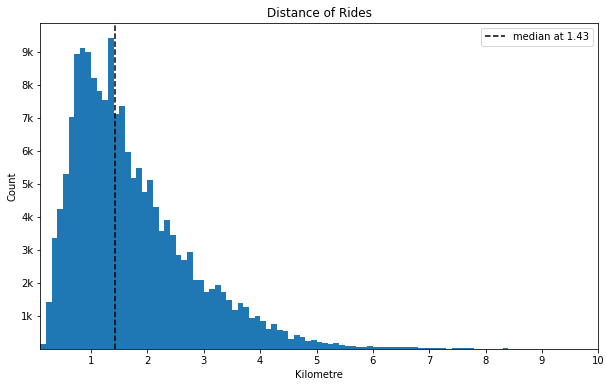

In [480]:
# start with distance
plt.figure(figsize=[10, 6])

bins = np.arange(0, 10 + 0.1, 0.1)

plt.hist(data=df, x='distance', bins= bins)

# add ticks for x axis
xticks = np.arange(0, 10 + 1, 1)
plt.xticks(xticks)

# add ticks for y axis
yticks = np.arange(1000, 10000, 1000)
ylabel = ['{}k'.format(el // 1000) for el in yticks]
plt.yticks(yticks, ylabel)

# zoom in. there are outliers in the df
plt.xlim([0.1, 10])

# add title and label
plt.title("Distance of Rides")
plt.xlabel("Kilometre")
plt.ylabel("Count")

# add a vertical line for median
med = df.distance.median()
plt.axvline(x=med, color='k', linestyle='--', label="median at {:.2f}".format(med))

plt.legend()

plt.show()

Since the ``distance`` feature is a quantitative continuous variable, a histogram can be applied for its visualization. As we can see on the above graph, there are a few peaks and valleys; Yet there are two main ones. Therefore, it is a **bimodal histogram**. 

A vertical line that represents the median has been added to the graph. The line tells us **half of our users choose to use our shared bicycles when the trip is less than 1.43 kilometers**. As the distance increases, the user's count using the shared bicycles gradually decreases on the vertical line's right. Therefore, the ``distance`` feature has a **right-skewed** distribution. By analogy, **people tend to move out from our shared bicycles when the distance to a location is more significant than 1.43 kilometers**.

During the building of the above visulization, some surprises on the dataset were found.

1. As we can see in the data frame below, this lady biked 70 kilometers in 1.93 hours. The calculated time is around 5 hours and 19 minutes on Google Map for this trip. The event should consider as a miracle for her.

In [383]:
df.query("distance >= 69")[['start_station_name', 'end_station_name', 'member_gender', 'distance', 'duration_sec']]

,start_station_name,end_station_name,member_gender,distance,duration_sec
112038,Montgomery St BART Station (Market St at 2nd St),Palm St at Willow St,Female,69.465977,6945


Since the above row's distance is a bias, the above graph has zoomed in to display most of the data points.

2. Another unique point occurs when the distance is zero. About 3.5K rides ended at the same position; The starting point is the same as the ending point. Since we cannot track the distance when the two points are the same, the above graph has set the starting ticks as 0.1 using the ``xlim`` method.

We have seen how the distribution of the distance is plotted. A quick insight from the graph is **most people would consider using our bikes when the location is not too far away**. However, some rows' **starting and ending location data are the same** (mentioned on point 2, above). We should also look at the average duration people spend on our bikes.

### How long does the average trip take?

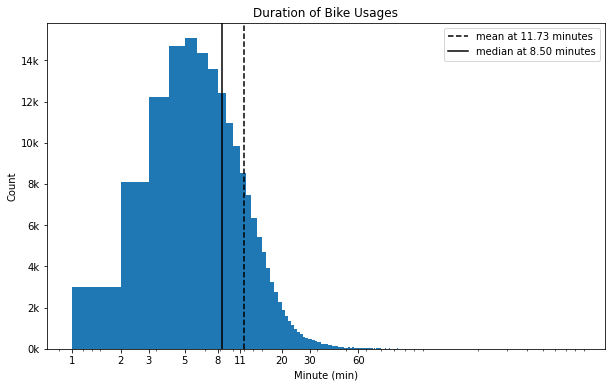

In [481]:
plt.figure(figsize=[10, 6])

bins = np.arange(60, df.duration_sec.max() + 60, 60)
plt.hist(data=df, x='duration_sec', bins=bins)
plt.xscale("log")

ticks = [60, 120, 180, 300, 480, 660, 1200, 1800, 3600]
label = [1, 2, 3, 5, 8, 11, 20, 30, 60]
plt.xticks(ticks, label)

# add ticks for y axis
yticks = np.arange(0, 14000 + 2000, 2000)
ylabel = ['{}k'.format(el // 1000) for el in yticks]
plt.yticks(yticks, ylabel)

# add a vertical line for mean, and median
mean = df.duration_sec.mean()
med = df.duration_sec.median()
plt.axvline(x=mean, color='k', linestyle='--', label="mean at {:.2f} minutes".format(mean / 60))
plt.axvline(x=med, color='k', linestyle='solid', label="median at {:.2f} minutes".format(med / 60))
plt.legend()

plt.title("Duration of Bike Usages")
plt.xlabel("Minute (min)")
plt.ylabel("Count")

plt.show()

We are interested in the average duration of a trip. Here is the feature related to the duration in the data frame: 

* ``duration_sec``: duration in seconds.

As shown in the figure, the distribution of the plot is right-skewed and unimodal. Two vertical lines represent the mean, and the median has been added to the plot. The median suggested that half of the rides were done in no more than 8.5 minutes, while the average among all trips is 11.73 minutes. Again, the graph tells us **our shared bicycles are lucrative on a quick and short journey**.

One factor we need to consider for increasing our bike usages is the time people use our bikes.

### When are most trips taken in terms of the time of the day?

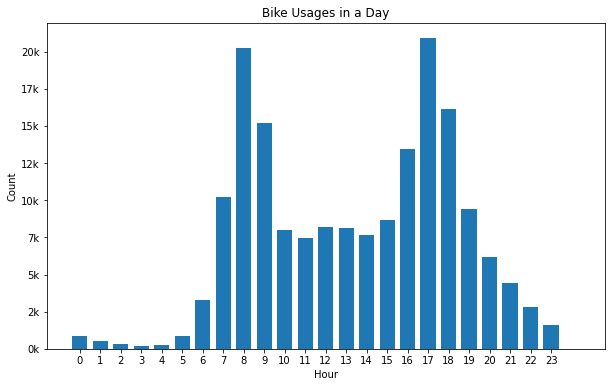

In [482]:
plt.figure(figsize=[10, 6])

bin_edges = np.arange(-0.5, 24.5 + 1, 1)
plt.hist(df.start_time.dt.hour, bins=bin_edges, rwidth=0.75)

xticks = np.arange(0, 24, 1)
plt.xticks(xticks)

# add ticks for y axis
yticks = np.arange(0, 20000 + 2500, 2500)
ylabel = ['{}k'.format(el // 1000) for el in yticks]
plt.yticks(yticks, ylabel)

plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Bike Usages in a Day")

plt.show()

Time can either be **categorical** or **quantitative**, depending on our condition (hours, seasons, and years). Since we are interested in bike usages in terms of the day, we will group time in terms of hours. There are 24 hours in a day, and each hour is representing as a bar on the graph. As we can see in the above figure, the distribution of the variable is bimodal. Most importantly, the figure suggests that we have many rides at the following time:

* 7:00 am - 9:00 am.
* 4:00 pm - 6:00 pm.

In common sense, this is our commuter time. Is our bikes the main transportation for a commuter? We cannot tell since the data frame does not have enough useful information. However, we can figure out the day of the week people are using our shared bikes.

### When are most trips taken in terms of the day of the week?

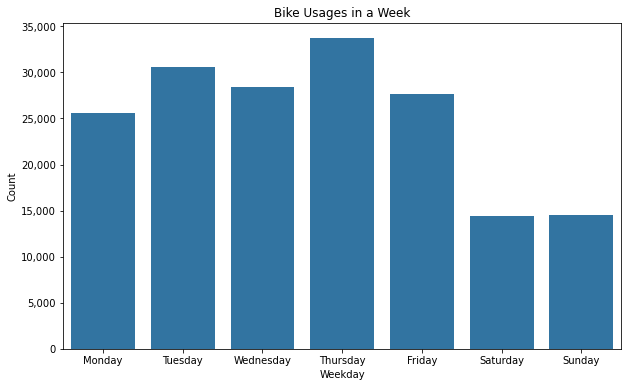

In [476]:
plt.figure(figsize=[10, 6])

base_color = sns.color_palette()[0]
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.countplot(x=df.start_time.dt.day_name(), color=base_color, order=order)

# add ticks for y axis
yticks = np.arange(0, 35000 + 5000, 5000)
ylabel = ['{:,}'.format(el) for el in yticks]
plt.yticks(yticks, ylabel)

plt.xlabel("Weekday")
plt.ylabel("Count")
plt.title("Bike Usages in a Week");

We can see that most bike usages are performed on weekdays, but do they all have the same distribution on hourly bike usage?

## Bivariate Exploration

### Is the distribution of hourly bike usage the same for all days of the week?

In [391]:
df['hour'] = df.start_time.dt.hour
df['day_name'] = df.start_time.dt.day_name()

# Convert the ``day_name``j column from a plaion object type into an ordered categforical type
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = pd.api.types.CategoricalDtype(ordered=True, categories=days)
df['day_name'] = df['day_name'].astype(days)

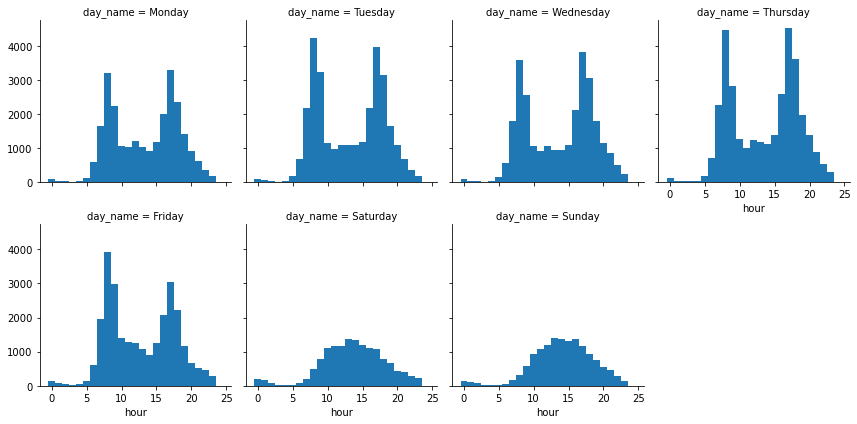

In [400]:
g = sns.FacetGrid(data=df, col="day_name", col_wrap=4, margin_titles=True)
g.map(plt.hist, 'hour', bins=bin_edges);

As we can see on the above graphs, the distribution is very similar for all weekdays - a bimodal distribution. The statement **our bikes are the main transportation for commuters** is likely to be true. The distribution of weekends, on the other hand, is symmetric. 

To summarise, our bikes are trendy for a short and quick trip, and people tend to use them for rush hours. However, where should we place all our bikes? We need to know where are all the bike ages coming from.

### What locations do people use our bikes?

In [416]:
# Bounding Box is the area defined by two longitudes and two latitudes that will include all spatial points.
BBox = (df.start_station_longitude.min(), df.start_station_longitude.max(), 
        df.start_station_latitude.min(), df.start_station_latitude.max())

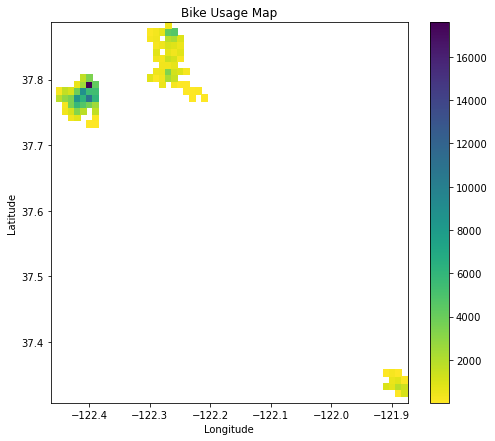

In [466]:
plt.figure(figsize=[8, 7])

bins_x = np.arange(BBox[0] - 0.01, BBox[1] + 0.01, 0.01)
bins_y = np.arange(BBox[2] - 0.01, BBox[3] + 0.01, 0.01)

plt.hist2d(data=df, x="start_station_longitude", y="start_station_latitude", cmin=0.01, cmap="viridis_r", bins=[bins_x, bins_y]);
plt.colorbar()

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bike Usage Map")

plt.show()

<div style="padding-left: 50px;">
    
<p>
By looking at the heat map and the image from below, it is clear that most of our bike usages are coming from the modernized area; Namely, San Fransico, Berkeley, and San Jose.
</p>
    
<img src="./map.png" style="float: left; width: 600px;" />
</div>

Now, everything we have considered so far was related to a general user. However, there are different types of users in the dataset. Moreover, different gender and age groups might have different contributions to the usage of our shared bicycles.

### When are most trips taken in terms of the day of the week for each user group?

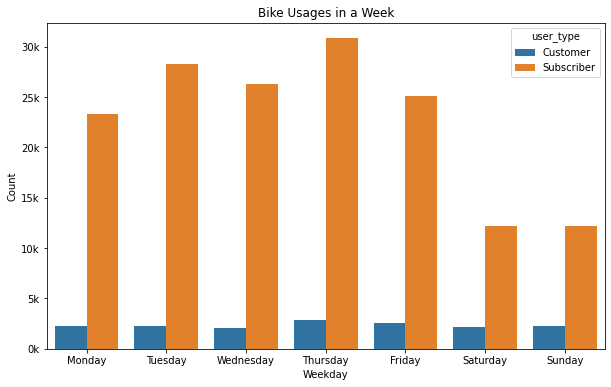

In [483]:
plt.figure(figsize=[10, 6])

sns.countplot(data=df, x="day_name", hue="user_type")

# add ticks for y axis
yticks = np.arange(0, 30000 + 5000, 5000)
ylabel = ['{}k'.format(el // 1000) for el in yticks]
plt.yticks(yticks, ylabel)

plt.xlabel("Weekday")
plt.ylabel("Count")
plt.title("Bike Usages in a Week");

As we can see in the above figure, the difference between customer and subscriber has a drastic difference in bike usage. In other words, most of our profits are coming from the subscriber. 

## Multivariate Exploration

Since bike usages has a great diffence in two user groups, we need to take a closer look of when each user group use the shared bikes.

In [485]:
df['age'] = 2021 - df['member_birth_year']

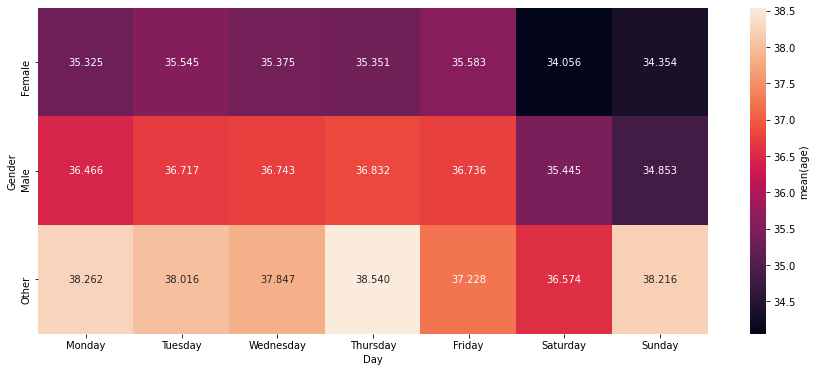

In [501]:
plt.figure(figsize=[15, 6])

cat_means = df.groupby(["day_name", "member_gender"]).mean()['age']
cat_means = cat_means.reset_index(name="age_avg")
cat_means = cat_means.pivot(index="member_gender", columns="day_name", values="age_avg")

sns.heatmap(cat_means, annot=True, fmt=".3f", cbar_kws={"label":"mean(age)"});

plt.xlabel("Day")
plt.ylabel("Gender");

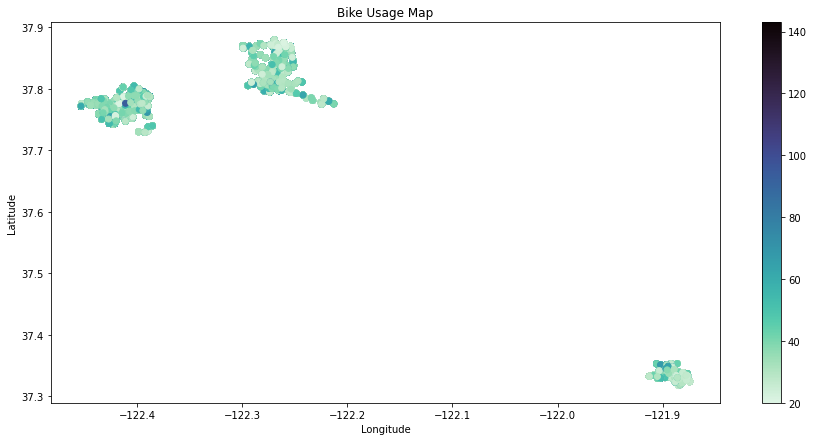

In [507]:
plt.figure(figsize=[15, 7])

plt.scatter(data=df, x="start_station_longitude", y="start_station_latitude", c="age", cmap="mako_r");
plt.colorbar()

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bike Usage Map")

plt.show()

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!